In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import tensorflow as tf
import keras.layers as layers
from tensorflow.keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import re
import string
import numpy as np
import pandas as pd

2022-12-15 21:08:37.709396: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# experiment name
name = 'both_generated_using_correct_names_40k_better_repeatedfunction'

# Dataset

In [4]:
df = pd.read_csv(f"data/{name}.csv")
print(df.shape)
df.sample(10)

(40000, 2)


,Name,class
30439,للحياء ومكانه أسعاره,0.0
7850,شعلان مارفين حميدوا,1.0
8864,محمديوسف رايه جنةالله,1.0
38141,طارق غغنندوور سيدرا,0.0
619,ادوارد طمه عبير,1.0
29555,ويعود أعداد واليأس,0.0
32198,ددععهه ندييللاا لننا,0.0
39182,الحلوجى مم فيلو,0.0
26047,سععععل صصلاة اا,0.0
11313,عبدالملك الزير عطاء,1.0


In [5]:
# max number of words per name
df['Name'].str.split().str.len().max()

3

In [6]:
df.head(5)

,Name,class
0,حمايه تيسير لاوند,1.0
1,سعداحمد ابراهبم برى,1.0
2,مكة ولاء كريمه,1.0
3,زايد ثراء سحاق,1.0
4,الاسمر الشندى العوضى,1.0


In [7]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Name,class
0,هةة ااب ااسسنن,0.0
1,للزوار صحيفة شرير,0.0
2,شحاته رضى بريقع,1.0
3,المغازى رابحه ايمن,1.0
4,ىصوا ىافاوئل نلاارو,0.0


## Document Preprocessing

In [8]:
# adding start and end tokens
names = ['<SOS> ' + x + ' <EOS>' for x in df['Name'].tolist()]
corpus = " ".join(names)
labels = df['class'].tolist()
corpus[:1000]

'<SOS> هةة ااب ااسسنن <EOS> <SOS> للزوار صحيفة شرير <EOS> <SOS> شحاته رضى بريقع <EOS> <SOS> المغازى رابحه ايمن <EOS> <SOS> ىصوا ىافاوئل نلاارو <EOS> <SOS> سعاده عدلان سياده <EOS> <SOS> ميينن شكلت فصار <EOS> <SOS> يكسر بأسعار والأكل <EOS> <SOS> قائما المط البلاط <EOS> <SOS> ماريف بطاح الفروجى <EOS> <SOS> انتصار مشيل فردوس <EOS> <SOS> نبوى إجازة تصويرها <EOS> <SOS> ودبي محافظ ايتناه <EOS> <SOS> صصققر بب للييدى <EOS> <SOS> لإنها يطاق آسيا <EOS> <SOS> خليل معين ملكى <EOS> <SOS> بههء اهه صصبرراا <EOS> <SOS> ابال انعم اميمه <EOS> <SOS> شفيقه تميمى محمدعبدالمقصود <EOS> <SOS> الرحله سد والشاطئ <EOS> <SOS> الدسوقى الجميعى حسام <EOS> <SOS> هديه حمايه جنين <EOS> <SOS> العبدالسيد بسمة مؤيد <EOS> <SOS> نرمين محمدالمرسى الزيان <EOS> <SOS> عوضين عيدى رابحة <EOS> <SOS> ايه عبدالحاكم باهر <EOS> <SOS> عبدالخبير شحتة ماضى <EOS> <SOS> الخلط اولاد فقه <EOS> <SOS> عبدالنافع كك تادرس <EOS> <SOS> اميره ابوغنام عبدالرءوف <EOS> <SOS> المؤدي ادهم نريامكي <EOS> <SOS> ابحصلىا ويصاف نا <EOS> <SOS> مساوئ قفمو وتفاجأ

## Tokenization 

In [9]:
tokenize = tf.keras.preprocessing.text.Tokenizer(oov_token="<UNK>", filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', lower=False)
tokenize.fit_on_texts(names)
x = tokenize.texts_to_sequences(names)
max_len = 6
x = tf.keras.utils.pad_sequences(x, maxlen=max_len, padding='post')
total_words = len(tokenize.word_index)+1
print(f"Total Words: {total_words}")
print("Example of a Sequence")
print(x[:3])
print("Some Tokens")
print(list(tokenize.word_index)[:100])

Total Words: 15085
Example of a Sequence
[[    2  8840  2991  5589     3     0]
 [    2  4765  5590 12993     3     0]
 [    2   817   818  3453     3     0]]
Some Tokens
['<UNK>', '<SOS>', '<EOS>', 'اا', 'د', 'ر', 'م', 'ا', 'مم', 'ن', 'س', 'ل', 'و', 'لل', 'ى', 'ي', 'رر', 'معز', 'مر', 'ارزاق', 'ثريا', 'الشربينى', 'فيروزه', 'الو', 'بب', 'نو', 'فى', 'يزن', 'قق', 'ميمى', 'لله', 'مروى', 'يي', 'روح', 'نمر', 'جاسر', 'ح', 'القداح', 'جان', 'وفاء', 'عا', 'اعتماد', 'فاخر', 'ترك', 'محب', 'نظار', 'بيلاجيا', 'نا', 'السطل', 'حرب', 'شا', 'بساده', 'اوسامة', 'رحب', 'توما', 'هاله', 'ملكى', 'زكريا', 'البونى', 'سامية', 'المنصان', 'سلامه', 'وعد', 'مير', 'مسعود', 'شبل', 'اثر', 'حمد', 'طيرالوادى', 'لى', 'روميساء', 'زيزى', 'مسك', 'نبوى', 'مظهر', 'مدنى', 'غاندى', 'وى', 'يمة', 'عويضه', 'جما', 'هاتم', 'احلام', 'عبادة', 'تهامى', 'عبدالوراث', 'المنير', 'محمدالنبوى', 'ادور', 'فيولا', 'وصفى', 'موده', 'حكمه', 'سجى', 'ره', 'فاهم', 'اسعد', 'ايمن', 'معين', 'عبدالخبير']


## Splitting data and making dataset 

In [10]:
x_train, x_valid, y_train, y_valid = train_test_split(x, df['class'].values, test_size=.2, random_state=23)
print("Train and Validation sizes")
len(x_train), len(x_valid), len(y_train), len(y_valid)

Train and Validation sizes


(32000, 8000, 32000, 8000)

In [11]:
y_train.sum(), y_valid.sum()

(16054.0, 3946.0)

In [12]:
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
ds_valid = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(128)

2022-12-15 21:08:41.219828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 21:08:41.254648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 21:08:41.254913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 21:08:41.255789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [13]:
for x,y in ds_train.take(1):
    print(x[:2], y[:2])

tf.Tensor(
[[    2  4379   272 11252     3     0]
 [    2  6358   737  7164     3     0]], shape=(2, 6), dtype=int32) tf.Tensor([0. 0.], shape=(2,), dtype=float64)


# Build and Train a Model: 

In [14]:
vocab_size = total_words
embedding_dim = 64
sequence_length = max_len

In [15]:
model = tf.keras.Sequential([
  layers.Embedding(vocab_size, embedding_dim),
  layers.Dropout(0.4),
  layers.GlobalAveragePooling1D(),
  layers.Dense(1)],
  )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          965440    
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 965,505
Trainable params: 965,505
Non-trainable params: 0
_________________________________________________________________


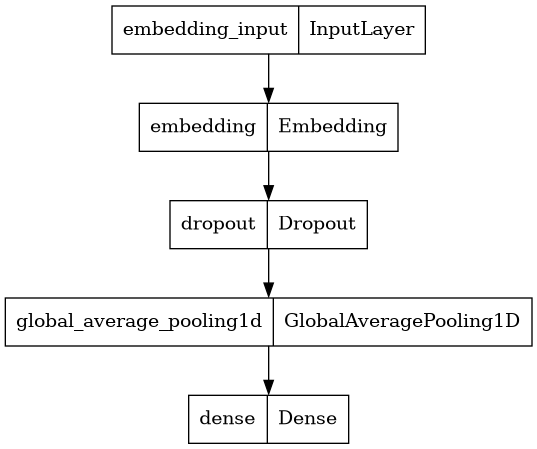

In [16]:
plot_model(model)

In [16]:
model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy())

In [17]:
early_stopping = EarlyStopping(patience=2, restore_best_weights=True, verbose=True)
epochs = 100
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=epochs,
    callbacks=[early_stopping])

Epoch 1/100
250/250 [==============================] - 2s 6ms/step - loss: 0.6362 - binary_accuracy: 0.5061 - val_loss: 0.5274 - val_binary_accuracy: 0.5558
Epoch 2/100
250/250 [==============================] - 1s 4ms/step - loss: 0.3692 - binary_accuracy: 0.9048 - val_loss: 0.2672 - val_binary_accuracy: 0.9779
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 0.1785 - binary_accuracy: 0.9864 - val_loss: 0.1617 - val_binary_accuracy: 0.9719
Epoch 4/100
250/250 [==============================] - 1s 4ms/step - loss: 0.1085 - binary_accuracy: 0.9895 - val_loss: 0.1224 - val_binary_accuracy: 0.9718
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0773 - binary_accuracy: 0.9930 - val_loss: 0.1041 - val_binary_accuracy: 0.9719
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0586 - binary_accuracy: 0.9954 - val_loss: 0.0940 - val_binary_accuracy: 0.9716
Epoch 7/100
250/250 [==============================] - 1s 

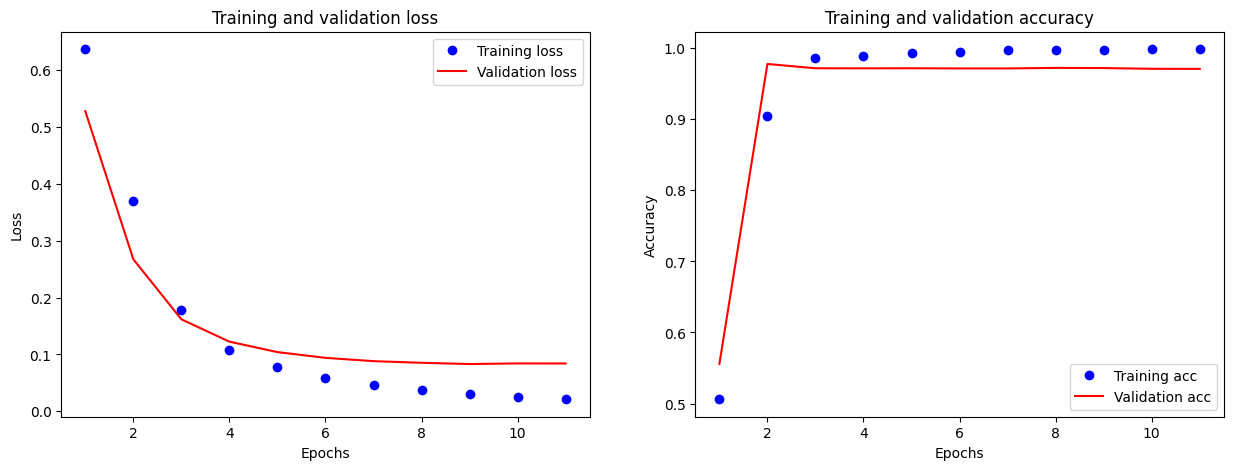

In [18]:
from utils import plot_history
plot_history(history.history)

### Test Examples 

In [19]:
#new
example = '<sos> ' + "معاذ طه عوض" + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 72ms/step


array([[0.9999385]], dtype=float32)

In [20]:
#new
example = "باسم وحيد السيد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 36ms/step


array([[0.99458885]], dtype=float32)

In [21]:
#new
example = "شسي شسي شسي"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 31ms/step


array([[0.39239052]], dtype=float32)

In [22]:
#new
example = "باسمم وحةد السد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 30ms/step


array([[0.39239052]], dtype=float32)

In [23]:
#new
example = "مريم محمد محمد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 36ms/step


array([[0.9972264]], dtype=float32)

In [24]:
#new
example = "محمد مريم محمد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 31ms/step


array([[0.9972264]], dtype=float32)

In [25]:
#new
example = "مريم محمد على"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 30ms/step


array([[0.99485457]], dtype=float32)

In [26]:
#new
example = "محمد طه عوض"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 36ms/step


array([[0.9993736]], dtype=float32)

In [27]:
#new
example = "فوزىىى محسمد شنش"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 33ms/step


array([[0.39239052]], dtype=float32)

In [33]:
#new
example = "دزيادد عبت محمد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 40ms/step


array([[0.8305756]], dtype=float32)

In [34]:
#new
example = "محمد طه عوض لاشين"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 30ms/step


array([[0.9998258]], dtype=float32)

In [35]:
#new
example = "زيادي ممسسيشي شسيسيد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 33ms/step


array([[0.39239052]], dtype=float32)

# Saving and loading the trained model 

In [36]:
model.save(f'models/{name}_base_model.h5', )

In [37]:
new_model = tf.keras.models.load_model(f'models/{name}_base_model.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          965440    
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 965,505
Trainable params: 965,505
Non-trainable params: 0
_________________________________________________________________


## Saving and loading the tokenizer

In [38]:
import pickle

# saving
with open(f'models/{name}tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenize, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open(f'models/{name}tokenizer.pickle', 'rb') as handle:
    new_tokenizer = pickle.load(handle)

In [39]:
#new
example = "محمد طه عوض لاشين"
example = '<sos> ' + example + ' <eos>'
example_vect = new_tokenizer.texts_to_sequences([example])
tf.nn.sigmoid(new_model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 77ms/step


array([[0.9998258]], dtype=float32)